<a href="https://colab.research.google.com/github/xo-bot1997/Project-Repository/blob/main/Climate_Case_Zambia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Load the data
climate_data = pd.read_csv('climate_data.csv')
# Display the first few rows of the dataset
climate_data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DEWP,GUST,MAX,MIN,MXSPD,PRCP,TEMP,VISIB,WDSP
0,67599099999,"MFUWE, ZA",-13.266667,31.933333,570.0,7/29/1993,49.9,999.9,87.8,53.6,999.9,0.0,78.7,18.6,999.9
1,67599099999,"MFUWE, ZA",-13.266667,31.933333,570.0,9/13/1993,9999.9,999.9,95.5,60.8,7.0,0.0,78.1,6.2,3.2
2,67599099999,"MFUWE, ZA",-13.266667,31.933333,570.0,9/27/1993,53.7,999.9,96.8,84.0,999.9,0.0,92.9,12.4,999.9
3,67599099999,"MFUWE, ZA",-13.266667,31.933333,570.0,10/6/1993,57.6,999.9,98.6,66.6,9.9,0.0,82.3,12.4,7.4
4,67599099999,"MFUWE, ZA",-13.266667,31.933333,570.0,10/15/1993,62.5,999.9,97.9,63.5,9.9,0.0,93.3,12.4,8.4


In [ ]:
# Convert DATE column to datetime format
climate_data['DATE'] = pd.to_datetime(climate_data['DATE'])
# Verify the conversion
print(climate_data['DATE'].head())

0   1993-07-29
1   1993-09-13
2   1993-09-27
3   1993-10-06
4   1993-10-15
Name: DATE, dtype: datetime64[ns]


In [ ]:
# Replace sentinel values with NaN
sentinel_values = [9999.9, 999.99, 999.9]  # Add other sentinel values if necessary
climate_data.replace(sentinel_values, np.nan, inplace=True)

# Handle missing values
climate_data.fillna(method='ffill', inplace=True)
climate_data.fillna(method='bfill', inplace=True)

# Display basic info
info = climate_data.info()
print(info)

# Ensure no sentinel values are left
print(climate_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51999 entries, 0 to 51998
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   STATION    51999 non-null  int64         
 1   NAME       51999 non-null  object        
 2   LATITUDE   51999 non-null  float64       
 3   LONGITUDE  51999 non-null  float64       
 4   ELEVATION  51999 non-null  float64       
 5   DATE       51999 non-null  datetime64[ns]
 6   DEWP       51999 non-null  float64       
 7   GUST       51999 non-null  float64       
 8   MAX        51999 non-null  float64       
 9   MIN        51999 non-null  float64       
 10  MXSPD      51999 non-null  float64       
 11  PRCP       51999 non-null  float64       
 12  TEMP       51999 non-null  float64       
 13  VISIB      51999 non-null  float64       
 14  WDSP       51999 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memory usage: 6.0+ MB
None
     

In [ ]:
# Convert categorical columns to appropriate types
climate_data['STATION'] = climate_data['STATION'].astype(str)
climate_data['NAME'] = climate_data['NAME'].astype('category')

# Convert temperatures from Fahrenheit to Celsius
climate_data['TEMP_C'] = (climate_data['TEMP'] - 32) * 5.0/9.0

# Convert dew point from Fahrenheit to Celsius
climate_data['DEWP_C'] = (climate_data['DEWP'] - 32) * 5.0/9.0

# Display the first few rows to verify the changes
climate_data[['TEMP_C', 'DEWP_C']].head()


,TEMP_C,DEWP_C
0,25.944444,9.944444
1,25.611111,9.944444
2,33.833333,12.055556
3,27.944444,14.222222
4,34.055556,16.944444


In [ ]:
print(climate_data.describe())

           LATITUDE     LONGITUDE     ELEVATION  \
count  51999.000000  51999.000000  51999.000000   
mean     -14.197814     27.983320   1192.348249   
min      -17.800000     22.700000   -999.900000   
25%      -15.333333     25.816667   1078.000000   
50%      -15.066667     28.450000   1151.830000   
75%      -12.983333     28.650000   1270.100000   
max       -8.850000     33.200000   1673.000000   
std        2.193787      2.520088    162.912985   

                                DATE          DEWP          GUST  \
count                          51999  51999.000000  51999.000000   
mean   1993-12-25 21:23:22.157733888     54.136199     21.091265   
min              1973-01-01 00:00:00      7.900000      6.000000   
25%              1985-07-15 00:00:00     46.600000     11.100000   
50%              1990-07-03 00:00:00     54.500000     22.900000   
75%              1998-08-01 12:00:00     62.600000     27.000000   
max              2023-12-31 00:00:00     77.500000     58.300000

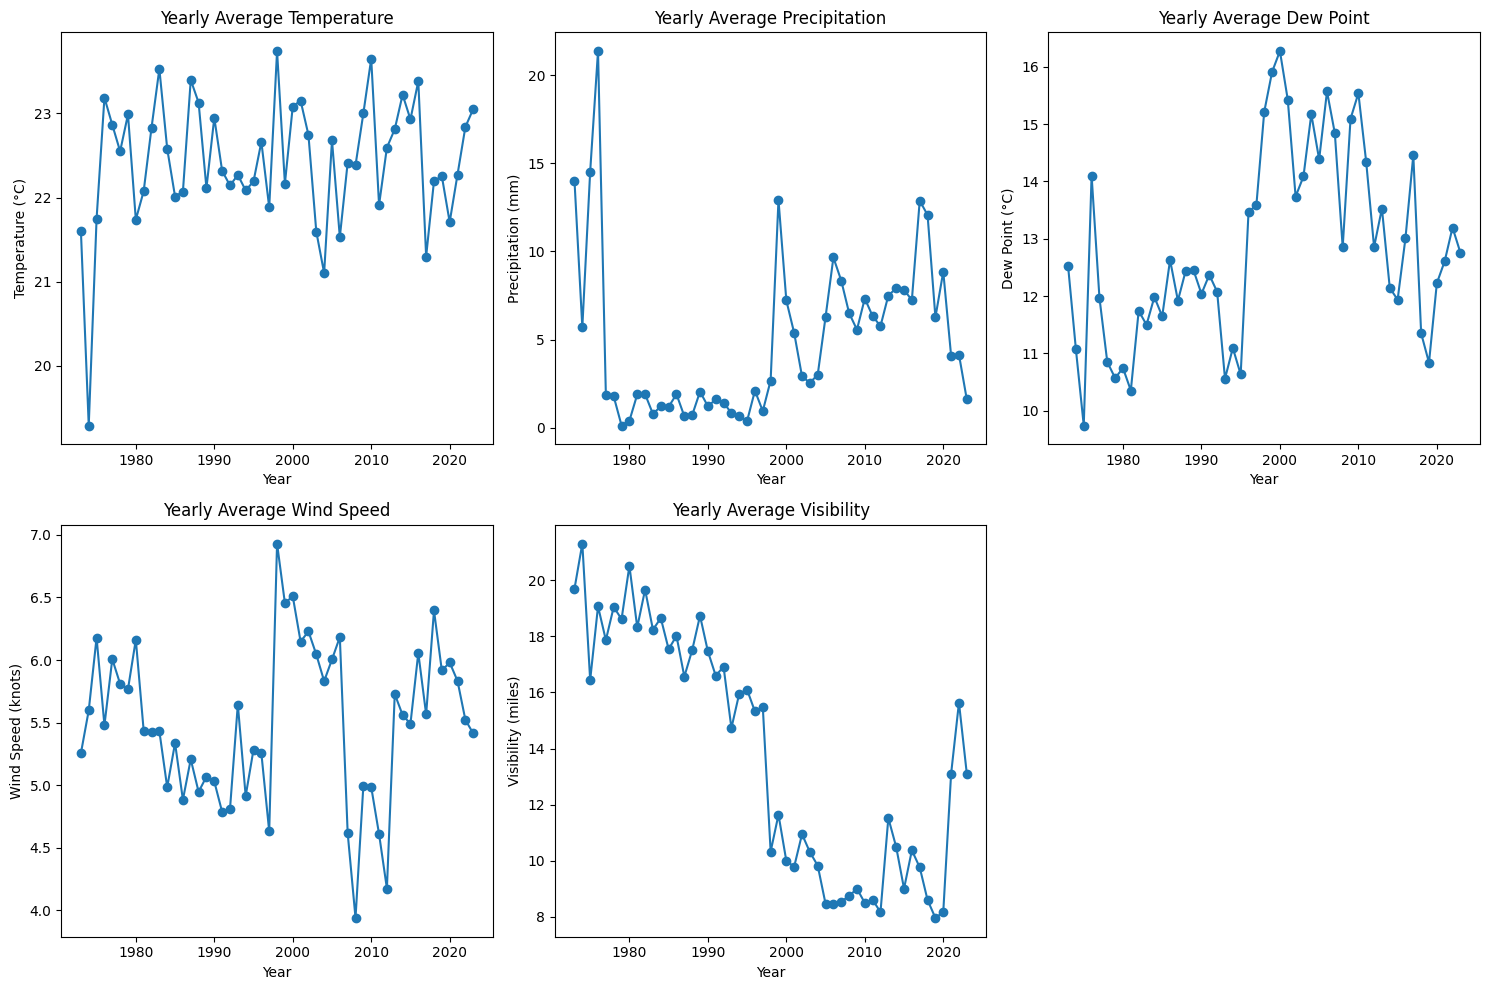

In [ ]:
# Ensure 'DATE' is in datetime format and set as index
climate_data['DATE'] = pd.to_datetime(climate_data['DATE'])
climate_data.set_index('DATE', inplace=True)

# Select only numeric columns
numeric_cols = ['TEMP_C', 'PRCP', 'DEWP_C', 'WDSP', 'VISIB']
yearly_data = climate_data[numeric_cols].resample('Y').mean()

# Plot the yearly averages for temperature, precipitation, dew point, wind speed, and visibility
plt.figure(figsize=(15, 10))

# Temperature
plt.subplot(2, 3, 1)
plt.plot(yearly_data.index.year, yearly_data['TEMP_C'], marker='o')
plt.title('Yearly Average Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')

# Precipitation
plt.subplot(2, 3, 2)
plt.plot(yearly_data.index.year, yearly_data['PRCP'], marker='o')
plt.title('Yearly Average Precipitation')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')

# Dew Point
plt.subplot(2, 3, 3)
plt.plot(yearly_data.index.year, yearly_data['DEWP_C'], marker='o')
plt.title('Yearly Average Dew Point')
plt.xlabel('Year')
plt.ylabel('Dew Point (°C)')

# Wind Speed
plt.subplot(2, 3, 4)
plt.plot(yearly_data.index.year, yearly_data['WDSP'], marker='o')
plt.title('Yearly Average Wind Speed')
plt.xlabel('Year')
plt.ylabel('Wind Speed (knots)')

# Visibility
plt.subplot(2, 3, 5)
plt.plot(yearly_data.index.year, yearly_data['VISIB'], marker='o')
plt.title('Yearly Average Visibility')
plt.xlabel('Year')
plt.ylabel('Visibility (miles)')

plt.tight_layout()
plt.show()

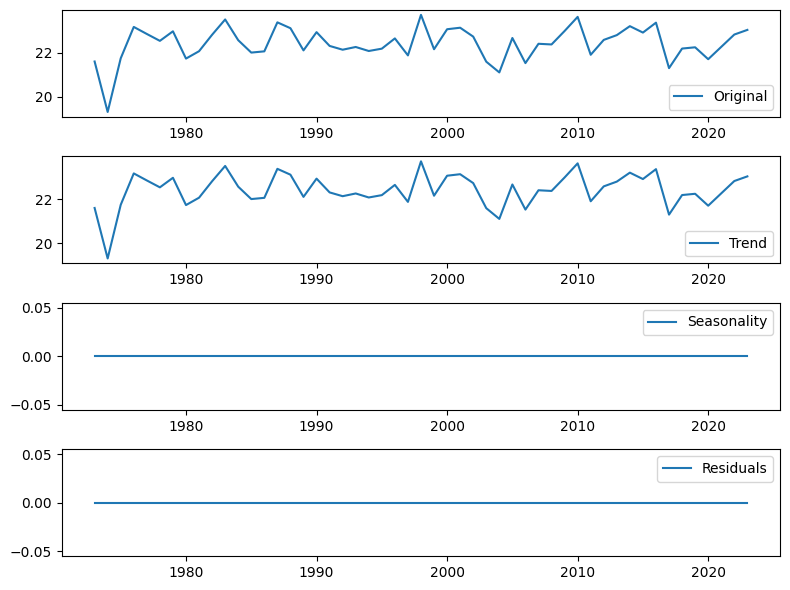

Stationarity test for TEMP_C:
Results of Dickey-Fuller Test:
Test Statistic                -5.730684e+00
p-value                        6.611269e-07
#Lags Used                     0.000000e+00
Number of Observations Used    5.000000e+01
Critical Value (1%)           -3.568486e+00
Critical Value (5%)           -2.921360e+00
Critical Value (10%)          -2.598662e+00
dtype: float64




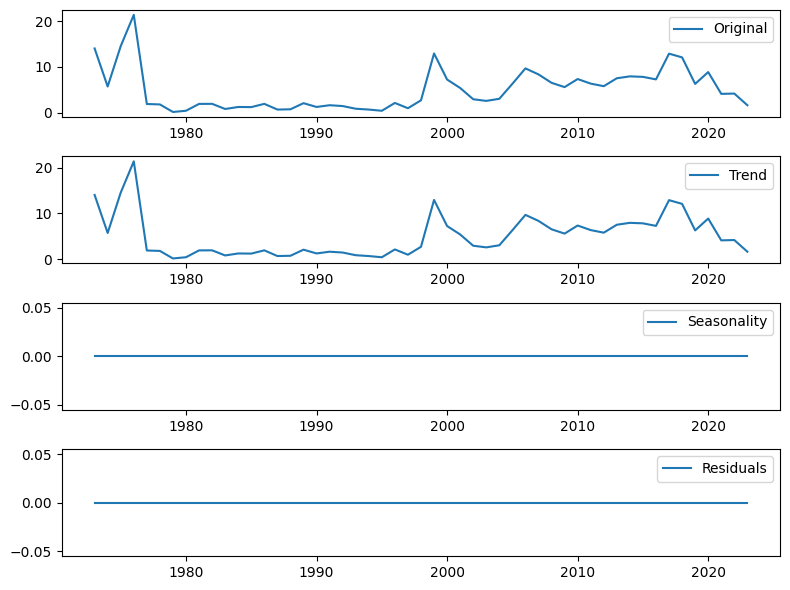

Stationarity test for PRCP:
Results of Dickey-Fuller Test:
Test Statistic                 -3.964938
p-value                         0.001606
#Lags Used                      0.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64




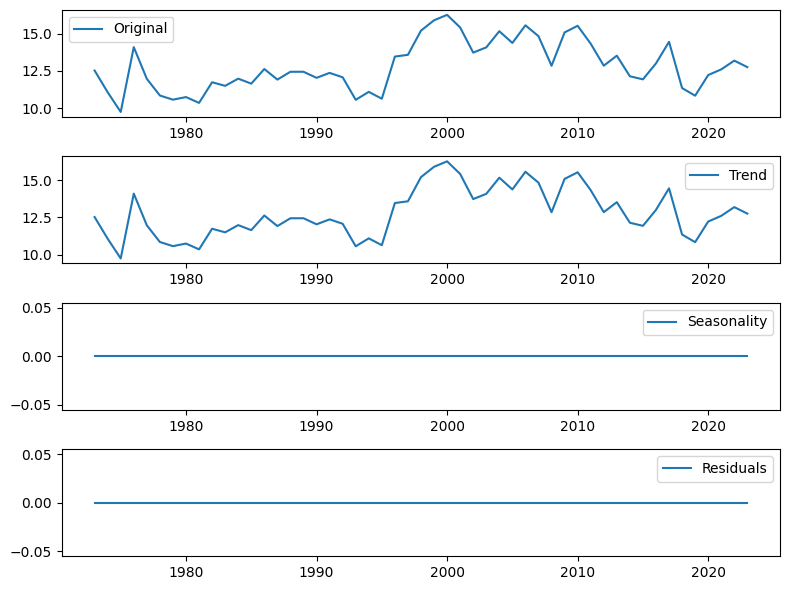

Stationarity test for DEWP_C:
Results of Dickey-Fuller Test:
Test Statistic                 -2.983467
p-value                         0.036467
#Lags Used                      0.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64




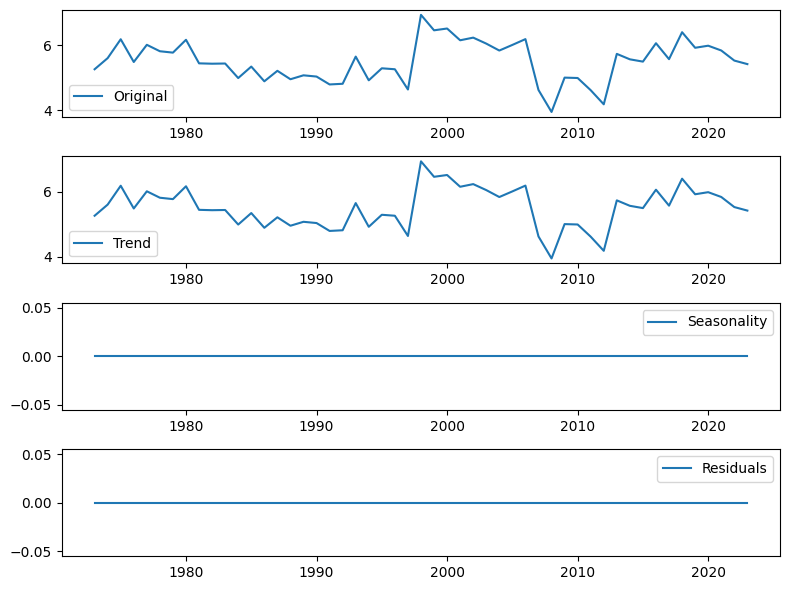

Stationarity test for WDSP:
Results of Dickey-Fuller Test:
Test Statistic                 -4.298921
p-value                         0.000446
#Lags Used                      8.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64




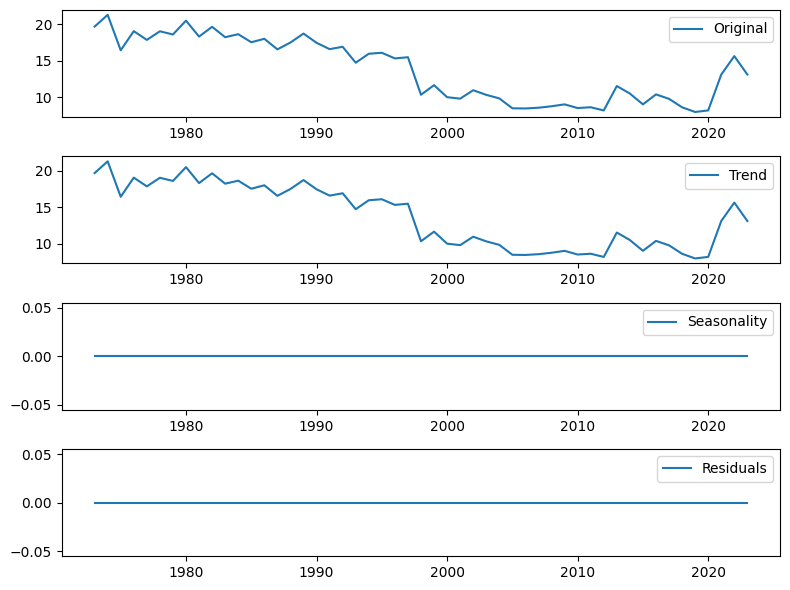

Stationarity test for VISIB:
Results of Dickey-Fuller Test:
Test Statistic                 -1.790993
p-value                         0.384942
#Lags Used                      0.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64




In [ ]:
# Function to test stationarity
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# Decomposing and testing stationarity for each target variable
target_variables = ['TEMP_C', 'PRCP', 'DEWP_C', 'WDSP', 'VISIB']

for variable in target_variables:
    # Decompose time series
    decomposition = seasonal_decompose(yearly_data[variable], model='additive', period=1)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot decomposition
    plt.figure(figsize=(8, 6))
    plt.subplot(411)
    plt.plot(yearly_data.index.year, yearly_data[variable], label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(yearly_data.index.year, trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(yearly_data.index.year, seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(yearly_data.index.year, residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Test stationarity on the original time series
    print(f'Stationarity test for {variable}:')
    test_stationarity(yearly_data[variable])
    print('\n')

In [ ]:
# Ensure all relevant columns are numeric
columns_to_check = ['TEMP_C', 'DEWP_C', 'WDSP', 'PRCP', 'VISIB']
climate_data[columns_to_check] = climate_data[columns_to_check].apply(pd.to_numeric, errors='coerce')

# Monthly Aggregation, EXCLUDING 'NAME' column
monthly_data = climate_data[columns_to_check].resample('M').mean()
# Select only the numeric columns for aggregation



In [ ]:
# Prepare the data for the VAR model
var_data = monthly_data[columns_to_check].dropna()

# Split data into training (before 2021) and testing (2021-2023)
train = var_data[var_data.index.year < 2021]
test = var_data[var_data.index.year >= 2021]

# Vector AutoRegression (VAR) Model
model = VAR(train)
lag_order = model.select_order().aic
var_model = model.fit(lag_order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


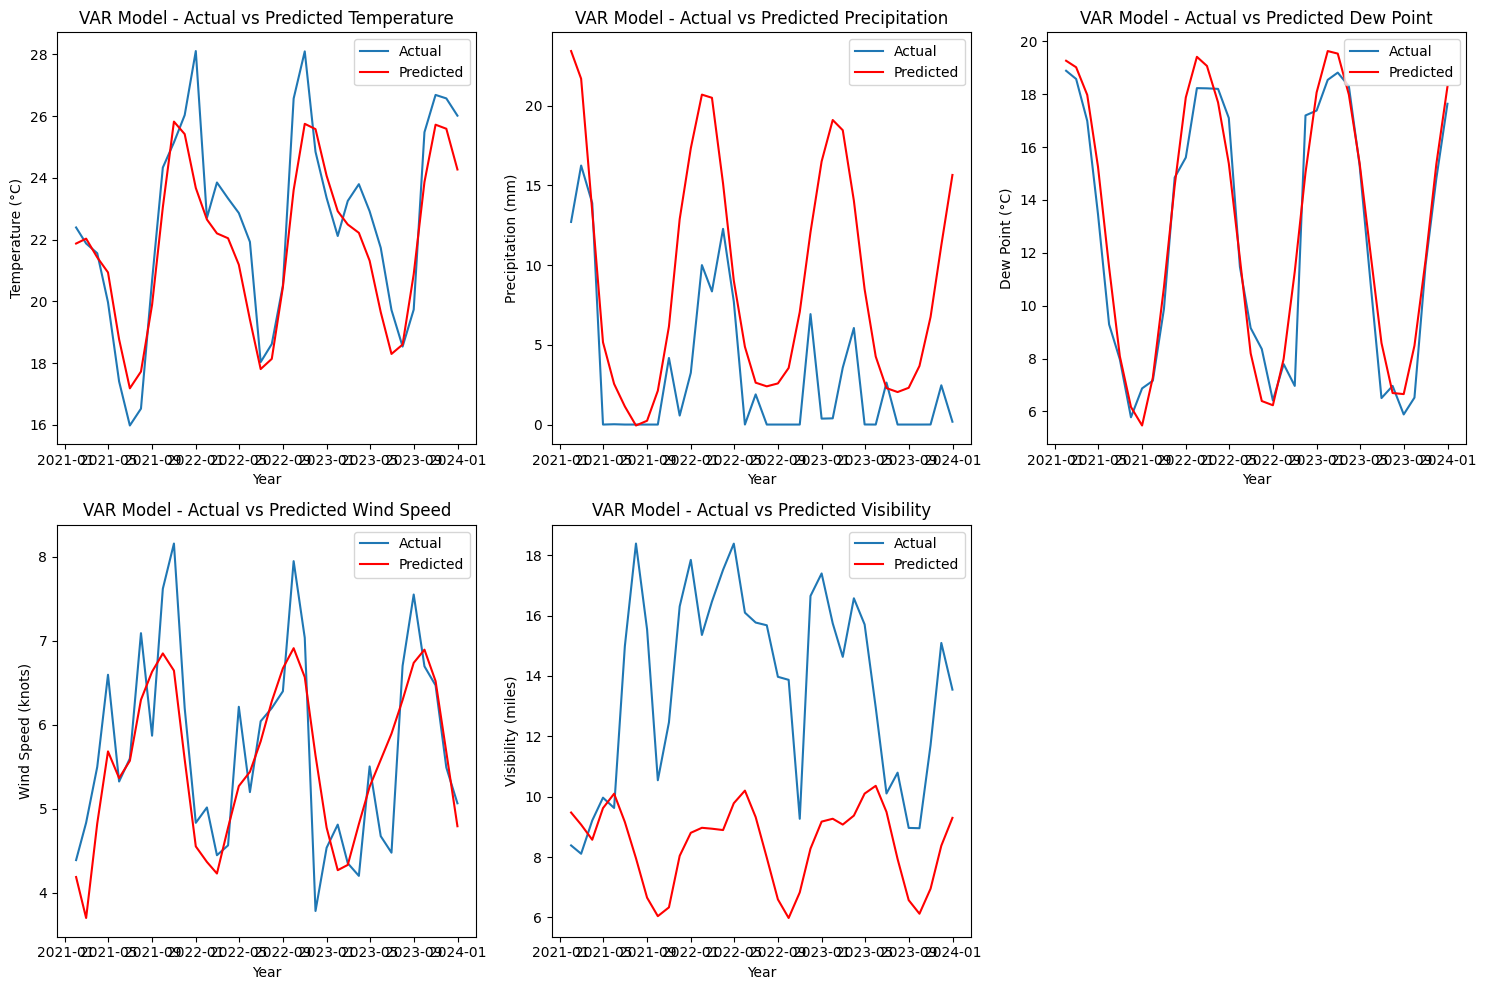

In [ ]:
# Forecasting for 2021-2023
forecast_steps = len(test)
forecast_var = var_model.forecast(train.values[-lag_order:], steps=forecast_steps)
forecast_var_df = pd.DataFrame(forecast_var, index=test.index, columns=columns_to_check)

# Plot the forecast against actual values
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(test.index, test['TEMP_C'], label='Actual')
plt.plot(forecast_var_df.index, forecast_var_df['TEMP_C'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('VAR Model - Actual vs Predicted Temperature')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(test.index, test['PRCP'], label='Actual')
plt.plot(forecast_var_df.index, forecast_var_df['PRCP'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('VAR Model - Actual vs Predicted Precipitation')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(test.index, test['DEWP_C'], label='Actual')
plt.plot(forecast_var_df.index, forecast_var_df['DEWP_C'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Dew Point (°C)')
plt.title('VAR Model - Actual vs Predicted Dew Point')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(test.index, test['WDSP'], label='Actual')
plt.plot(forecast_var_df.index, forecast_var_df['WDSP'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Wind Speed (knots)')
plt.title('VAR Model - Actual vs Predicted Wind Speed')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(test.index, test['VISIB'], label='Actual')
plt.plot(forecast_var_df.index, forecast_var_df['VISIB'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Visibility (miles)')
plt.title('VAR Model - Actual vs Predicted Visibility')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation Metrics
mae_values = {
    'TEMP_C': mean_absolute_error(test['TEMP_C'], forecast_var_df['TEMP_C']),
    'DEWP_C': mean_absolute_error(test['DEWP_C'], forecast_var_df['DEWP_C']),
    'WDSP': mean_absolute_error(test['WDSP'], forecast_var_df['WDSP']),
    'PRCP': mean_absolute_error(test['PRCP'], forecast_var_df['PRCP']),
    'VISIB': mean_absolute_error(test['VISIB'], forecast_var_df['VISIB'])
}

rmse_values = {
    'TEMP_C': np.sqrt(mean_squared_error(test['TEMP_C'], forecast_var_df['TEMP_C'])),
    'DEWP_C': np.sqrt(mean_squared_error(test['DEWP_C'], forecast_var_df['DEWP_C'])),
    'WDSP': np.sqrt(mean_squared_error(test['WDSP'], forecast_var_df['WDSP'])),
    'PRCP': np.sqrt(mean_squared_error(test['PRCP'], forecast_var_df['PRCP'])),
    'VISIB': np.sqrt(mean_squared_error(test['VISIB'], forecast_var_df['VISIB']))
}

print('MAE Values:', mae_values)
print('RMSE Values:', rmse_values)

MAE Values: {'TEMP_C': 1.1898417161536652, 'DEWP_C': 1.0012191510255133, 'WDSP': 0.5510853901670765, 'PRCP': 6.094881536032216, 'VISIB': 5.387406786028841}
RMSE Values: {'TEMP_C': 1.486061764722597, 'DEWP_C': 1.3348179085420888, 'WDSP': 0.7085182023495799, 'PRCP': 8.001830315715283, 'VISIB': 6.113199449917958}


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Ensure all relevant columns are numeric
columns_to_check = ['TEMP_C', 'DEWP_C', 'WDSP', 'PRCP', 'VISIB']
monthly_data[columns_to_check] = monthly_data[columns_to_check].apply(pd.to_numeric, errors='coerce')

# Prepare the data for LSTM model
lstm_data = monthly_data[columns_to_check].dropna()

In [ ]:
# Split data into training (before 2021) and testing (2021-2023)
train = lstm_data[lstm_data.index.year < 2021]
test = lstm_data[lstm_data.index.year >= 2021]

# Scale the data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Prepare the data for LSTM input
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12  # Use past 12 months to predict the next month
X_train, y_train = create_dataset(scaled_train, look_back)
X_test, y_test = create_dataset(scaled_test, look_back)

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(look_back, len(columns_to_check))))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(len(columns_to_check)))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
563/563 - 11s - loss: 0.0265 - 11s/epoch - 20ms/step
Epoch 2/20
563/563 - 4s - loss: 0.0140 - 4s/epoch - 7ms/step
Epoch 3/20
563/563 - 5s - loss: 0.0114 - 5s/epoch - 8ms/step
Epoch 4/20
563/563 - 5s - loss: 0.0106 - 5s/epoch - 9ms/step
Epoch 5/20
563/563 - 4s - loss: 0.0100 - 4s/epoch - 7ms/step
Epoch 6/20
563/563 - 5s - loss: 0.0099 - 5s/epoch - 9ms/step
Epoch 7/20
563/563 - 6s - loss: 0.0096 - 6s/epoch - 11ms/step
Epoch 8/20
563/563 - 4s - loss: 0.0093 - 4s/epoch - 7ms/step
Epoch 9/20
563/563 - 5s - loss: 0.0091 - 5s/epoch - 9ms/step
Epoch 10/20
563/563 - 4s - loss: 0.0088 - 4s/epoch - 7ms/step
Epoch 11/20
563/563 - 4s - loss: 0.0085 - 4s/epoch - 7ms/step
Epoch 12/20
563/563 - 5s - loss: 0.0083 - 5s/epoch - 9ms/step
Epoch 13/20
563/563 - 4s - loss: 0.0082 - 4s/epoch - 8ms/step
Epoch 14/20
563/563 - 4s - loss: 0.0081 - 4s/epoch - 7ms/step
Epoch 15/20
563/563 - 5s - loss: 0.0080 - 5s/epoch - 9ms/step
Epoch 16/20
563/563 - 4s - loss: 0.0079 - 4s/epoch - 8ms/step
Epoch 17/20
5

In [ ]:
# Forecasting with LSTM
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Prepare the forecast dataframe
forecast_lstm_df = pd.DataFrame(test_predict, index=test.index[look_back:], columns=columns_to_check)


1/1 [==============================] - 0s 23ms/step


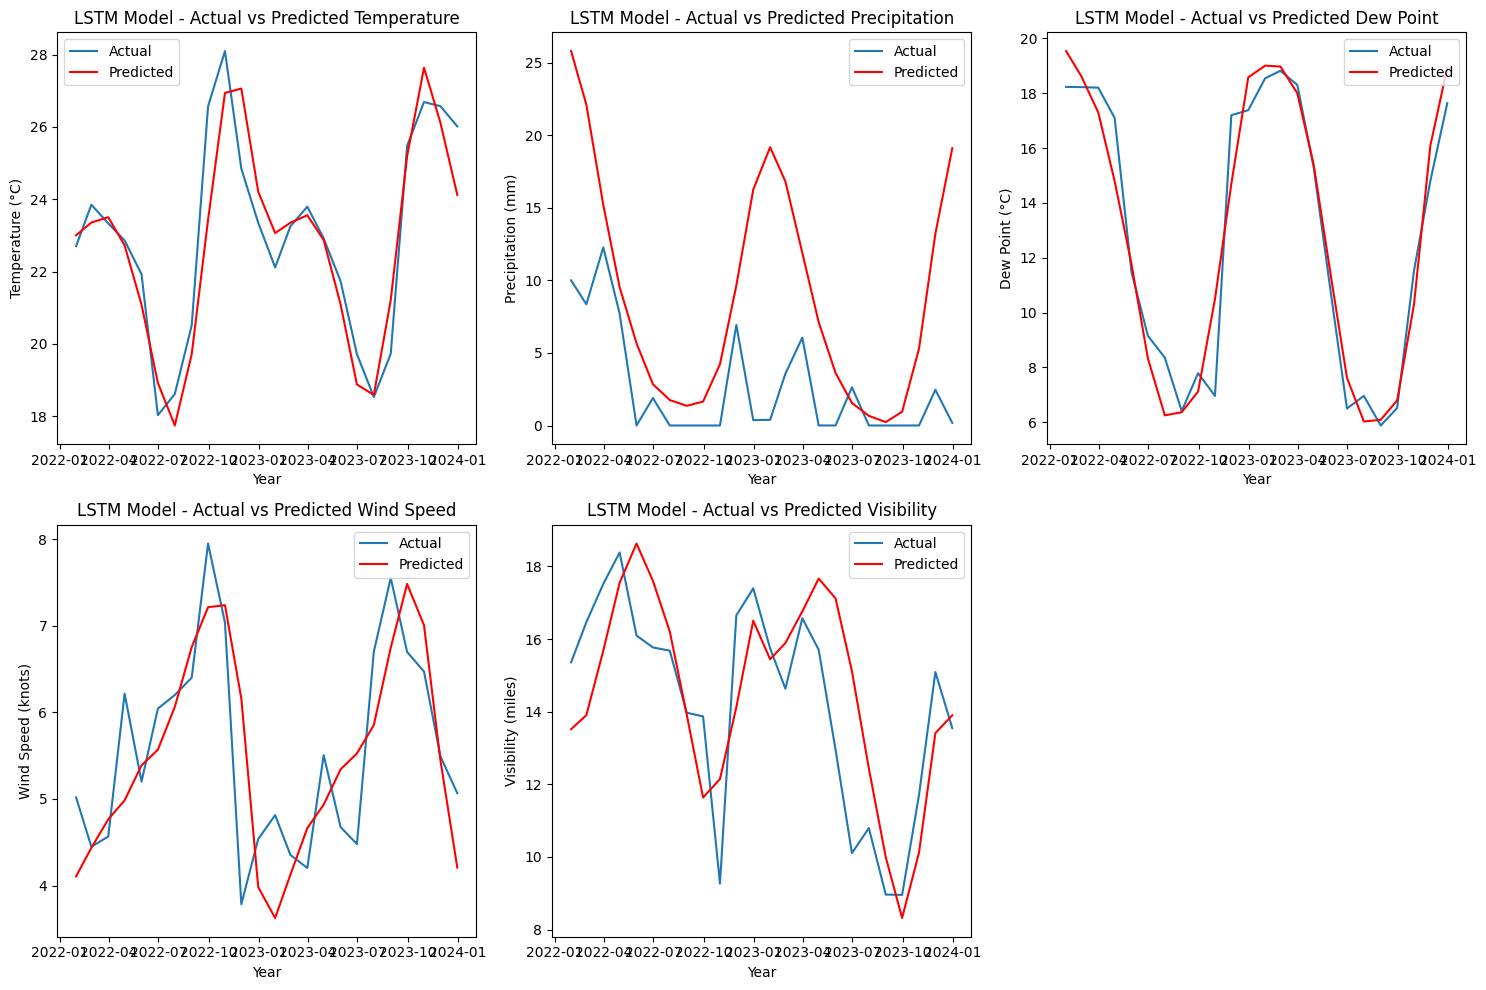

In [ ]:
# Plotting the LSTM forecast
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(test.index[look_back:], test['TEMP_C'][look_back:], label='Actual')
plt.plot(forecast_lstm_df.index, forecast_lstm_df['TEMP_C'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('LSTM Model - Actual vs Predicted Temperature')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(test.index[look_back:], test['PRCP'][look_back:], label='Actual')
plt.plot(forecast_lstm_df.index, forecast_lstm_df['PRCP'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('LSTM Model - Actual vs Predicted Precipitation')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(test.index[look_back:], test['DEWP_C'][look_back:], label='Actual')
plt.plot(forecast_lstm_df.index, forecast_lstm_df['DEWP_C'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Dew Point (°C)')
plt.title('LSTM Model - Actual vs Predicted Dew Point')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(test.index[look_back:], test['WDSP'][look_back:], label='Actual')
plt.plot(forecast_lstm_df.index, forecast_lstm_df['WDSP'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Wind Speed (knots)')
plt.title('LSTM Model - Actual vs Predicted Wind Speed')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(test.index[look_back:], test['VISIB'][look_back:], label='Actual')
plt.plot(forecast_lstm_df.index, forecast_lstm_df['VISIB'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Visibility (miles)')
plt.title('LSTM Model - Actual vs Predicted Visibility')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation Metrics
mae_values = {
    'TEMP_C': mean_absolute_error(test['TEMP_C'][look_back:], forecast_lstm_df['TEMP_C']),
    'DEWP_C': mean_absolute_error(test['DEWP_C'][look_back:], forecast_lstm_df['DEWP_C']),
    'WDSP': mean_absolute_error(test['WDSP'][look_back:], forecast_lstm_df['WDSP']),
    'PRCP': mean_absolute_error(test['PRCP'][look_back:], forecast_lstm_df['PRCP']),
    'VISIB': mean_absolute_error(test['VISIB'][look_back:], forecast_lstm_df['VISIB'])
}

rmse_values = {
    'TEMP_C': np.sqrt(mean_squared_error(test['TEMP_C'][look_back:], forecast_lstm_df['TEMP_C'])),
    'DEWP_C': np.sqrt(mean_squared_error(test['DEWP_C'][look_back:], forecast_lstm_df['DEWP_C'])),
    'WDSP': np.sqrt(mean_squared_error(test['WDSP'][look_back:], forecast_lstm_df['WDSP'])),
    'PRCP': np.sqrt(mean_squared_error(test['PRCP'][look_back:], forecast_lstm_df['PRCP'])),
    'VISIB': np.sqrt(mean_squared_error(test['VISIB'][look_back:], forecast_lstm_df['VISIB']))
}

print('MAE Values:', mae_values)
print('RMSE Values:', rmse_values)

MAE Values: {'TEMP_C': 0.8255048512669095, 'DEWP_C': 1.0022272499273814, 'WDSP': 0.6418937988482337, 'PRCP': 6.456364461277474, 'VISIB': 1.6820966899121599}
RMSE Values: {'TEMP_C': 1.1029977556671764, 'DEWP_C': 1.316975147509278, 'WDSP': 0.8129357101049648, 'PRCP': 8.8935048885407, 'VISIB': 2.0637880319038953}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Ensure all relevant columns are numeric
columns_to_check = ['TEMP_C', 'DEWP_C', 'WDSP', 'PRCP', 'VISIB']
monthly_data[columns_to_check] = monthly_data[columns_to_check].apply(pd.to_numeric, errors='coerce')

# Prepare the data for Random Forest model
rf_data = monthly_data[columns_to_check].dropna()

In [ ]:
# Create lag features
def create_lag_features(df, lags, target_col):
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

lags = 12  # Use past 12 months as lag features
for col in columns_to_check:
    rf_data = create_lag_features(rf_data, lags, col)

rf_data = rf_data.dropna()

# Split data into training (before 2021) and testing (2021-2023)
train = rf_data[rf_data.index.year < 2021]
test = rf_data[rf_data.index.year >= 2021]

# Create features and target for training and testing sets
def create_features_and_target(df, target_col):
    X = df.drop(columns=columns_to_check)
    y = df[target_col]
    return X, y


In [ ]:
# Train and predict using Random Forest for each variable
predictions = {}
for col in columns_to_check:
    X_train, y_train = create_features_and_target(train, col)
    X_test, y_test = create_features_and_target(test, col)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    predictions[col] = rf_model.predict(X_test)

# Prepare the forecast dataframe
forecast_rf_df = pd.DataFrame(predictions, index=test.index)

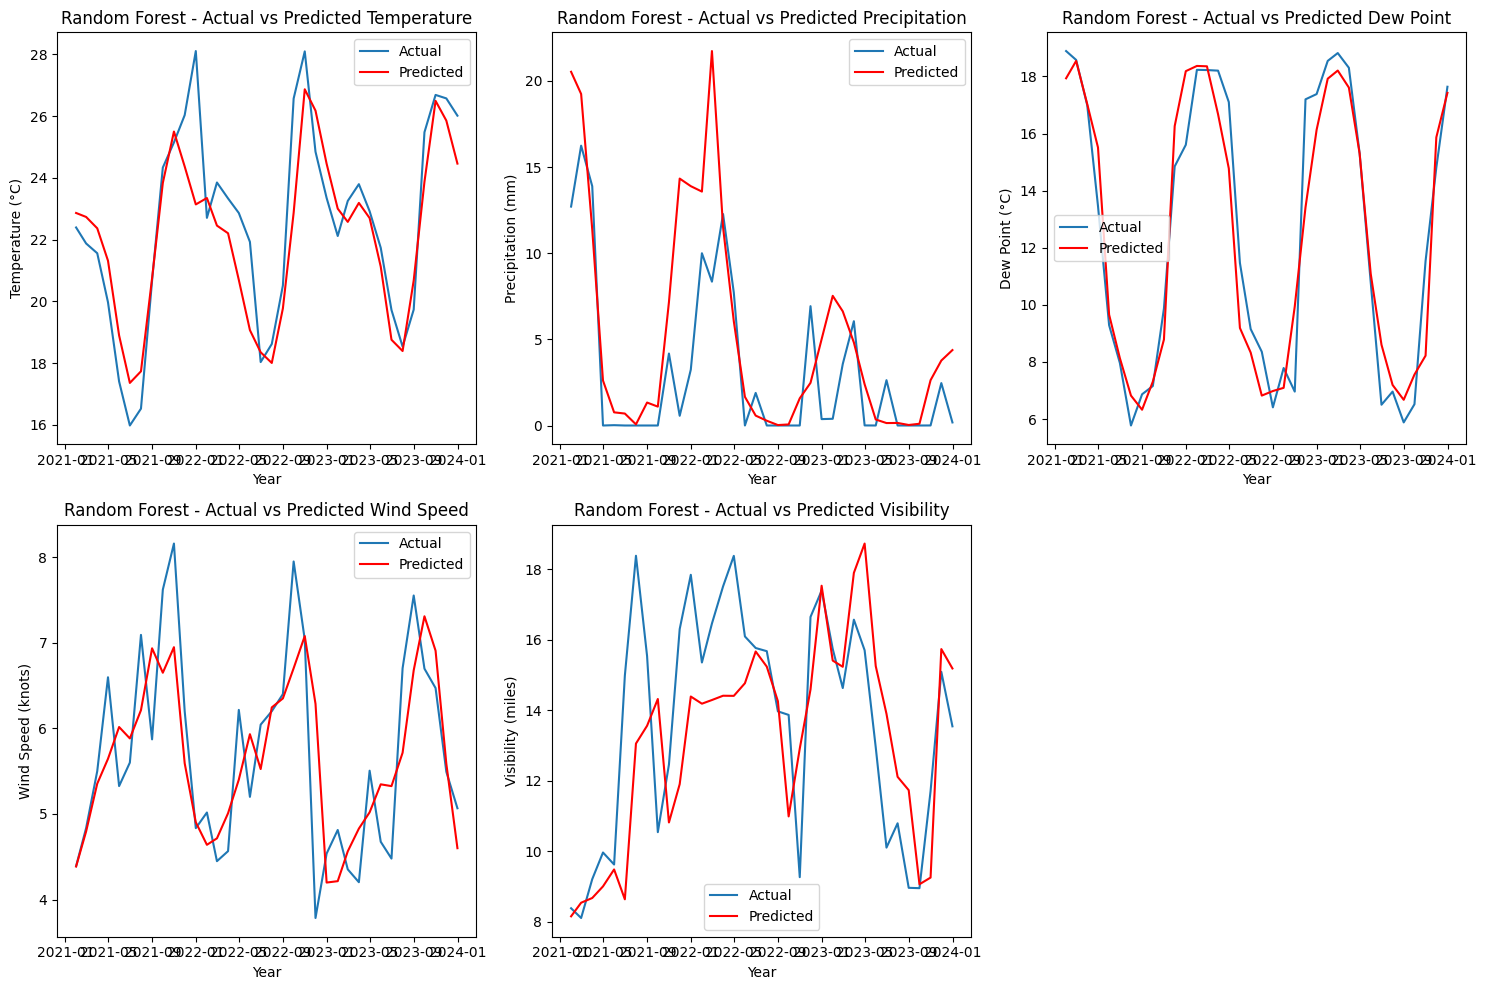

In [ ]:
# Plotting the Random Forest forecast
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(test.index, test['TEMP_C'], label='Actual')
plt.plot(forecast_rf_df.index, forecast_rf_df['TEMP_C'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Random Forest - Actual vs Predicted Temperature')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(test.index, test['PRCP'], label='Actual')
plt.plot(forecast_rf_df.index, forecast_rf_df['PRCP'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Random Forest - Actual vs Predicted Precipitation')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(test.index, test['DEWP_C'], label='Actual')
plt.plot(forecast_rf_df.index, forecast_rf_df['DEWP_C'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Dew Point (°C)')
plt.title('Random Forest - Actual vs Predicted Dew Point')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(test.index, test['WDSP'], label='Actual')
plt.plot(forecast_rf_df.index, forecast_rf_df['WDSP'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Wind Speed (knots)')
plt.title('Random Forest - Actual vs Predicted Wind Speed')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(test.index, test['VISIB'], label='Actual')
plt.plot(forecast_rf_df.index, forecast_rf_df['VISIB'], label='Predicted', color='red')
plt.xlabel('Year')
plt.ylabel('Visibility (miles)')
plt.title('Random Forest - Actual vs Predicted Visibility')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Evaluation Metrics
mae_values = {
    'TEMP_C': mean_absolute_error(test['TEMP_C'], forecast_rf_df['TEMP_C']),
    'DEWP_C': mean_absolute_error(test['DEWP_C'], forecast_rf_df['DEWP_C']),
    'WDSP': mean_absolute_error(test['WDSP'], forecast_rf_df['WDSP']),
    'PRCP': mean_absolute_error(test['PRCP'], forecast_rf_df['PRCP']),
    'VISIB': mean_absolute_error(test['VISIB'], forecast_rf_df['VISIB'])
}

rmse_values = {
    'TEMP_C': np.sqrt(mean_squared_error(test['TEMP_C'], forecast_rf_df['TEMP_C'])),
    'DEWP_C': np.sqrt(mean_squared_error(test['DEWP_C'], forecast_rf_df['DEWP_C'])),
    'WDSP': np.sqrt(mean_squared_error(test['WDSP'], forecast_rf_df['WDSP'])),
    'PRCP': np.sqrt(mean_squared_error(test['PRCP'], forecast_rf_df['PRCP'])),
    'VISIB': np.sqrt(mean_squared_error(test['VISIB'], forecast_rf_df['VISIB']))
}

print('MAE Values:', mae_values)
print('RMSE Values:', rmse_values)

MAE Values: {'TEMP_C': 1.1527744904790727, 'DEWP_C': 1.0961660766812171, 'WDSP': 0.5887883562640668, 'PRCP': 2.937246623395654, 'VISIB': 1.9684314131527205}
RMSE Values: {'TEMP_C': 1.5098995052235817, 'DEWP_C': 1.469753728933809, 'WDSP': 0.7583807917681623, 'PRCP': 4.542888378262804, 'VISIB': 2.535646626125709}
